In [ ]:
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
import pandas as pd
import os

class WhiteBalanceDatasetTest(Dataset):
    def __init__(self, csv_path, img_dir, transform=None, train=True):
        self.data = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.transform = transform
        self.train = train

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.img_dir, row['names'])
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        if img is None:
            raise FileNotFoundError(f"Не удалось загрузить изображение: {img_path}")
        img = img.astype(np.float32)
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED).astype(np.float32)
        img = img / 65535.0  # нормализация RAW в [0,1]
        img = cv2.resize(img, (224, 224))  # EfficientNet ожидает минимум 224×224
        img = torch.from_numpy(img).permute(2, 0, 1)  # HWC → CHW

        if self.train:
            label = torch.tensor([row['wp_r'], row['wp_g'], row['wp_b']], dtype=torch.float32)
            return img, label
        else:
            return img, row['names']

In [ ]:
from pathlib import Path

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset

class WhiteBalanceDataset(Dataset):
    def __init__(self, csv_path, img_dir, hist_dir, transform=None, train=True, use_hist=True):
        self.data = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.hist_dir = hist_dir
        self.transform = transform
        self.train = train
        self.use_hist = use_hist

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        # === Загружаем изображение ===
        img_path = os.path.join(self.img_dir, row['image_name'])
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        if img is None:
            raise FileNotFoundError(f"Не удалось загрузить изображение: {img_path}")
        img = img.astype(np.float32) / 65535.0
        img = cv2.resize(img, (224, 224))
        img = torch.from_numpy(img).permute(2, 0, 1)  # HWC → CHW

        # === Загружаем гистограмму (если нужно) ===
        hist_tensor = None
        if self.use_hist and self.hist_dir is not None:
            hist_path = os.path.join(self.hist_dir, row['image_name'])
            if not os.path.exists(hist_path):
                raise FileNotFoundError(f"Не удалось загрузить гистограмму: {hist_path}")

            hist = cv2.imread(hist_path, cv2.IMREAD_GRAYSCALE)
            hist = hist.astype(np.float32) / 255.0  # нормализация [0,1]
            hist = cv2.resize(hist, (128, 128))
            hist_tensor = torch.from_numpy(hist).unsqueeze(0)  # (1, 128, 128)

        # === Возвращаем данные ===
        if self.train:
            label = torch.tensor([row['wp_r'], row['wp_g'], row['wp_b']], dtype=torch.float32)
            if self.use_hist and hist_tensor is not None:
                return img, hist_tensor, label
            else:
                return img, label
        else:
            if self.use_hist and hist_tensor is not None:
                return img, hist_tensor, row['image_name']
            else:
                return img, row['image_name']


In [ ]:
def create_compatible_csv(existing_csv_path, output_csv_path):
    """Создает CSV файл с именами файлов без префикса пути"""
    df = pd.read_csv(existing_csv_path)

    # Извлекаем только имена файлов без путей
    if 'names' in df.columns:
        df['image_name'] = df['names'].apply(lambda x: Path(x).stem +'.png')
    else:
        # Предполагаем, что первая колонка содержит пути
        first_col = df.columns[0]
        df['image_name'] = df[first_col].apply(lambda x: Path(str(x)).stem + '.png')

    # Сохраняем только нужные колонки
    result_df = df[['image_name', 'wp_r', 'wp_g', 'wp_b']]
    result_df.to_csv(output_csv_path, index=False)
    print(f"Created compatible CSV: {output_csv_path}")
    print(f"Rows: {len(result_df)}")
    return result_df

# Использование
create_compatible_csv("/kaggle/input/testtrain/train (2).csv", "train3.csv")

Created compatible CSV: train3.csv
Rows: 570


,image_name,wp_r,wp_g,wp_b
0,0000.png,0.173683,0.508642,0.215429
1,0002.png,0.266894,0.956725,0.577948
2,0004.png,0.146930,0.495538,0.265573
3,0005.png,0.218046,0.712538,0.402101
4,0008.png,0.070384,0.183209,0.125570
...,...,...,...,...
565,0937.png,0.215597,0.226323,0.196691
566,0938.png,0.169317,0.299355,0.544165
567,0939.png,0.105052,0.339278,0.126710
568,0940.png,0.222516,0.693838,0.352222


In [ ]:
import pandas as pd

# путь к исходному csv
csv_path = "/kaggle/working/train3.csv"
out_path = "/kaggle/working/train_filtered.csv"

# читаем
df = pd.read_csv(csv_path)

print("До фильтрации:", df.shape)

# фильтруем строки где wp_g != 1.0
df_filtered = df[df["wp_g"] != 1.0].reset_index(drop=True)

print("После фильтрации:", df_filtered.shape)

# сохраняем
df_filtered.to_csv(out_path, index=False)
print(f"Сохранено в {out_path}")


До фильтрации: (570, 4)
После фильтрации: (561, 4)
Сохранено в /kaggle/working/train_filtered.csv


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.models as models
def get_model(name: str, pretrained: bool = False, out_dim: int = 3):
    """
    Возвращает model, ready for regression -> out_dim (3) with Sigmoid.
    Поддерживаем: 'efficientnet_b0', 'efficientnet_b3', 'resnet50', 'resnet18', 'mobilenet_v3_large'
    """
    name = name.lower()
    if name == "efficientnet_b0":
        m = models.efficientnet_b0(weights='DEFAULT' if pretrained else None)
        # replace classifier
        in_f = m.classifier[1].in_features if hasattr(m, "classifier") else 1280
        m.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_f, out_dim),
            nn.Sigmoid()
        )
        return m

    if name == "efficientnet_b3":
        m = models.efficientnet_b3(weights='DEFAULT' if pretrained else None)
        in_f = m.classifier[1].in_features
        m.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_f, out_dim),
            nn.Sigmoid()
        )
        return m

    if name == "resnet50":
        m = models.resnet50(weights='DEFAULT' if pretrained else None)
        in_f = m.fc.in_features
        m.fc = nn.Sequential(
            nn.Linear(in_f, out_dim),
            nn.Sigmoid()
        )
        return m

    if name == "resnet18":
        m = models.resnet18(weights='DEFAULT' if pretrained else None)
        in_f = m.fc.in_features
        m.fc = nn.Sequential(
            nn.Linear(in_f, out_dim),
            nn.Sigmoid()
        )
        return m

    if name == "mobilenet_v3_large":
        m = models.mobilenet_v3_large(weights='DEFAULT' if pretrained else None)
        in_f = m.classifier[0].in_features if hasattr(m, "classifier") else 1280
        m.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(in_f, out_dim),
            nn.Sigmoid()
        )
        return m

    if name == "vit_b_16":
        m = models.vit_b_16(weights="DEFAULT" if pretrained else None)
        in_f = m.heads.head.in_features
        m.heads = nn.Sequential(
            nn.Linear(in_f, out_dim),
            nn.Sigmoid()
        )
        return m

    if name == "convnext_base":
        m = models.convnext_base(weights="DEFAULT" if pretrained else None)
        in_f = m.classifier[2].in_features
        m.classifier = nn.Sequential(
            nn.Flatten(1),  # <--- добавляем flatten перед LayerNorm
            nn.LayerNorm(in_f, eps=1e-6),
            nn.Linear(in_f, out_dim),
            nn.Sigmoid()
        )
        return m


    if name == "convnext_tiny":
        m = models.convnext_tiny(weights="DEFAULT" if pretrained else None)
        in_f = m.classifier[2].in_features
        m.classifier = nn.Sequential(
            nn.LayerNorm(in_f, eps=1e-6),
            nn.Linear(in_f, out_dim),
            nn.Sigmoid()
        )
        return m

    if name == "swin_t":
        m = models.swin_t(weights="DEFAULT" if pretrained else None)
        in_f = m.head.in_features
        m.head = nn.Sequential(
            nn.Linear(in_f, out_dim),
            nn.Sigmoid()
        )
        return m

    if name == "densenet121":
        m = models.densenet121(weights="DEFAULT" if pretrained else None)
        in_f = m.classifier.in_features
        m.classifier = nn.Sequential(
            nn.Linear(in_f, out_dim),
            nn.Sigmoid()
        )
        return m
    if name == "mnasnet1_0":
        m = models.mnasnet1_0(weights="DEFAULT" if pretrained else None)
        in_f = m.classifier[-1].in_features
        m.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(in_f, out_dim),
            nn.Sigmoid()
        )
        return m
    if name == "swin_b":
        m = models.swin_b(weights="DEFAULT" if pretrained else None)
        in_f = m.head.in_features
        m.head = nn.Sequential(
            nn.Linear(in_f, out_dim),
            nn.Sigmoid()
        )
        return m
    if name == "t2t_vit":
        m = timm.create_model("t2t_vit_14", pretrained=pretrained, num_classes=out_dim)
        m.head = nn.Sequential(
            nn.Linear(m.head.in_features, out_dim),
            nn.Sigmoid()
        )
        return m
    if name == "vit_l_16":  # Vision Transformer Large/16
        m = models.vit_l_16(weights="DEFAULT" if pretrained else None)
        in_f = m.heads.head.in_features
        m.heads = nn.Sequential(
            nn.Linear(in_f, out_dim),
            nn.Sigmoid()
        )
        return m
    if name == 'cvt':
        model = timm.create_model("cvt_13", pretrained=pretrained)
        in_features = model.head.in_features
        model.head = nn.Linear(in_features, out_dim)
        return model
    if name == "crossvit_15_240":
        m = timm.create_model("crossvit_15_240", pretrained=pretrained, num_classes=0)

        # Получаем размерности признаков для обеих ветвей
        # Создаем тестовый вход и получаем размерности
        test_input = torch.randn(1, 3, 240, 240)
        with torch.no_grad():
            features = m.forward_features(test_input)
            feature_dims = [f.shape[-1] for f in features]

        # Создаем головы с правильными размерностями
        m.head = nn.ModuleList([
            nn.Linear(feature_dims[0], out_dim),
            nn.Linear(feature_dims[1], out_dim)
        ])

    else:
        raise ValueError(f"Unknown model name: {name}")

    return m
    if name == "maxvit_t":
        m = models.maxvit_t(weights="DEFAULT" if pretrained else None)
        in_f = m.classifier[5].in_features  # у MaxViT classifier = Sequential([... , Linear])
        m.classifier[5] = nn.Sequential(
            nn.Linear(in_f, out_dim),
            nn.Sigmoid()
        )
        return m
    if name == "levit":
        m = timm.create_model("levit_128s", pretrained=pretrained, num_classes=out_dim)
        m.head = nn.Sequential(
            nn.Linear(m.head.in_features, out_dim),
            nn.Sigmoid()
        )
        return m
    # --- DeiT через timm ---

    if name == "deit_base":
        timm_name = "deit_base_patch16_224"
    elif name == "deit_small":
        timm_name = "deit_small_patch16_224"
    else:
        timm_name = name  # если передан полный timm-имя

    # Создаём модель с нужным числом классов = out_dim (чтобы голова сразу имела правильную форму)
    # Если pretrained=True — timm попытается загрузить веса
    model = timm.create_model(timm_name, pretrained=pretrained, num_classes=out_dim)

    # timm обычно создаёт head без Sigmoid; заменим на (Linear -> Sigmoid) если нужно
    # У разных моделей имя головы может быть 'head' или 'classifier'
    if hasattr(model, "head"):
        # если head — линейный, заменим на Sequential
        try:
            in_f = model.head.in_features
            model.head = nn.Sequential(nn.Linear(in_f, out_dim), nn.Sigmoid())
        except Exception:
            # если head — уже nn.Sequential или другой тип, просто заменим полностью
            model.head = nn.Sequential(nn.Linear(model.num_features, out_dim), nn.Sigmoid())
    elif hasattr(model, "classifier"):
        try:
            in_f = model.classifier.in_features
            model.classifier = nn.Sequential(nn.Linear(in_f, out_dim), nn.Sigmoid())
        except Exception:
            model.classifier = nn.Sequential(nn.Linear(model.num_features, out_dim), nn.Sigmoid())
    else:
        # Last resort: add attribute 'head'
        model.head = nn.Sequential(nn.Linear(model.num_features, out_dim), nn.Sigmoid())

    return model

    raise ValueError(f"Unknown model name: {name}")



In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import timm

def get_model(name: str, pretrained: bool = False, out_dim: int = 3):
    name = name.lower()

    if name == "efficientnet_b0":
        m = models.efficientnet_b0(weights="DEFAULT" if pretrained else None)
        in_f = m.classifier[1].in_features
        m.classifier = nn.Sequential(nn.Dropout(0.3), nn.Linear(in_f, out_dim), nn.Sigmoid())
        return m

    elif name == "resnet50":
        m = models.resnet50(weights="DEFAULT" if pretrained else None)
        in_f = m.fc.in_features
        m.fc = nn.Sequential(nn.Linear(in_f, out_dim), nn.Sigmoid())
        return m

    elif name == "densenet121":
        m = models.densenet121(weights="DEFAULT" if pretrained else None)
        in_f = m.classifier.in_features
        m.classifier = nn.Sequential(nn.Linear(in_f, out_dim), nn.Sigmoid())
        return m
    elif name == "vit_l_16":  # Vision Transformer Large/16
        m = models.vit_l_16(weights="DEFAULT" if pretrained else None)
        in_f = m.heads.head.in_features
        m.heads = nn.Sequential(
            nn.Linear(in_f, out_dim),
            nn.Sigmoid()
        )
        return m
    # -------- timm модели --------
    elif name in ["deit_base", "deit_small"]:
        timm_name = {
            "deit_base": "deit_base_patch16_224",
            "deit_small": "deit_small_patch16_224",
        }[name]

        m = timm.create_model(timm_name, pretrained=pretrained, num_classes=out_dim)
        # добавим Sigmoid
        if hasattr(m, "head") and isinstance(m.head, nn.Linear):
            in_f = m.head.in_features
            m.head = nn.Sequential(nn.Linear(in_f, out_dim), nn.Sigmoid())
        return m

    elif name == "cvt":
        m = timm.create_model("cvt_13", pretrained=pretrained, num_classes=out_dim)
        return m

    elif name == "maxvit_t":
        m = timm.create_model("maxvit_tiny_tf_224", pretrained=pretrained, num_classes=out_dim)
        return m

    else:
        raise ValueError(f"Unknown model name: {name}")


Сохранено -> wb_examples/example_1.png


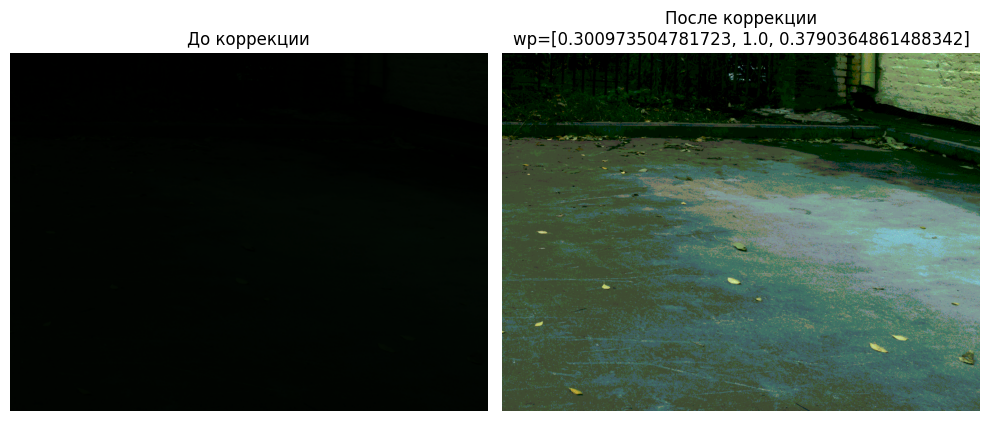

Сохранено -> wb_examples/example_2.png


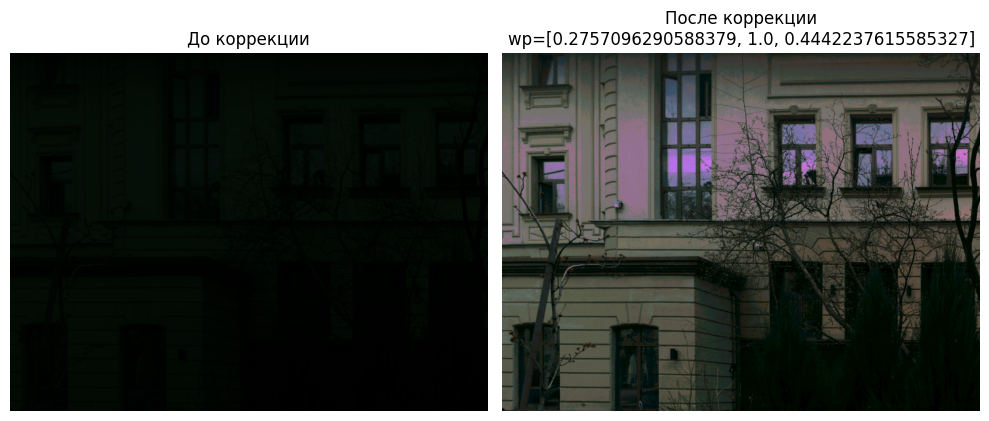

Сохранено -> wb_examples/example_3.png


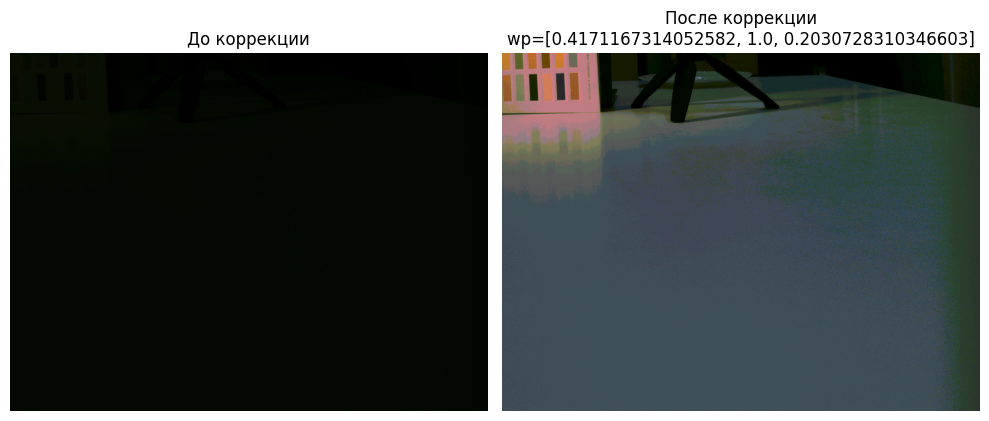

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# =========================
# Функция цветовой коррекции
# =========================
def apply_white_balance(img: np.ndarray, wp: np.ndarray, out_range=(0, 255)):
    """
    img: numpy array (H, W, 3) в диапазоне [0,255] uint8
    wp: numpy array (3,) предсказанная точка белого [wp_r, wp_g, wp_b]
    out_range: (min,max) диапазон выходного изображения
    """
    img = img.astype(np.float32) / 255.0  # в [0,1]
    wp = np.clip(wp, 1e-6, None)          # защита от деления на 0

    corrected = img / wp[np.newaxis, np.newaxis, :]  # применяем формулу
    corrected = corrected / corrected.max()          # нормализация
    corrected = np.clip(corrected, 0, 1)

    if out_range[1] == 255:
        corrected = (corrected * 255).astype(np.uint8)
    return corrected

# =========================
# Демонстрация
# =========================
def show_before_after(img_path, wp_pred, save_path=None):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    corrected = apply_white_balance(img, np.array(wp_pred))

    fig, axes = plt.subplots(1, 2, figsize=(10,5))
    axes[0].imshow(img)
    axes[0].set_title("До коррекции")
    axes[0].axis("off")
    axes[1].imshow(corrected)
    axes[1].set_title(f"После коррекции\nwp={wp_pred}")
    axes[1].axis("off")

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        print(f"Сохранено -> {save_path}")
    plt.show()

# =========================
# Пример использования
# =========================
# Пусть у нас есть 3 изображения (с разным освещением) и предсказания модели:
examples = [
    ("/kaggle/input/test-imgs/0001.png", [0.300973504781723, 1.0, 0.3790364861488342]),
    ("/kaggle/input/test-imgs/0015.png", [0.2757096290588379, 1.0, 0.4442237615585327]),
    ("/kaggle/input/test-imgs/0018.png", [0.4171167314052582, 1.0, 0.2030728310346603]),
]

os.makedirs("wb_examples", exist_ok=True)

for i, (img_path, wp_pred) in enumerate(examples, 1):
    save_path = f"wb_examples/example_{i}.png"
    show_before_after(img_path, wp_pred, save_path)


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import timm

def get_model(name: str, pretrained: bool = False, out_dim: int = 3):
    name = name.lower()

    if name == "efficientnet_b0":
        m = models.efficientnet_b0(weights="DEFAULT" if pretrained else None)
        in_f = m.classifier[1].in_features
        m.classifier = nn.Sequential(nn.Dropout(0.3), nn.Linear(in_f, out_dim), nn.Sigmoid())
        return m

    elif name == "resnet50":
        m = models.resnet50(weights="DEFAULT" if pretrained else None)
        in_f = m.fc.in_features
        m.fc = nn.Sequential(nn.Linear(in_f, out_dim), nn.Sigmoid())
        return m

    elif name == "densenet121":
        m = models.densenet121(weights="DEFAULT" if pretrained else None)
        in_f = m.classifier.in_features
        m.classifier = nn.Sequential(nn.Linear(in_f, out_dim), nn.Sigmoid())
        return m
    elif name == "vit_l_16":  # Vision Transformer Large/16
        m = models.vit_l_16(weights="DEFAULT" if pretrained else None)
        in_f = m.heads.head.in_features
        m.heads = nn.Sequential(
            nn.Linear(in_f, out_dim),
            nn.Sigmoid()
        )
        return m
 # -------- timm модели --------
    elif name in ["deit_base", "deit_small"]:
        timm_name = {
            "deit_base": "deit_base_patch16_224",
            "deit_small": "deit_small_patch16_224",
        }[name]

        m = timm.create_model(timm_name, pretrained=pretrained, num_classes=out_dim)
        # добавим Sigmoid
        if hasattr(m, "head") and isinstance(m.head, nn.Linear):
            in_f = m.head.in_features
            m.head = nn.Sequential(nn.Linear(in_f, out_dim), nn.Sigmoid())
        return m

    elif name == "cvt":
        m = timm.create_model("cvt_13", pretrained=pretrained, num_classes=out_dim)
        return m

    elif name == "maxvit_t":
        m = timm.create_model("maxvit_tiny_tf_224", pretrained=pretrained, num_classes=out_dim)
        return m

    elif name.startswith("convit"):
        # convit_tiny, convit_small, convit_base
        timm_name = {
            "convit_tiny": "convit_tiny",
            "convit_small": "convit_small",
            "convit_base": "convit_base",
        }[name]
        m = timm.create_model(timm_name, pretrained=pretrained, num_classes=out_dim)
        if hasattr(m, "head") and isinstance(m.head, nn.Linear):
            in_f = m.head.in_features
            m.head = nn.Sequential(nn.Linear(in_f, out_dim), nn.Sigmoid())
        return m

    elif name.startswith("levit"):
        # levit_128s, levit_192, levit_256, levit_384 и т.д.
        timm_name = name  # имя в timm совпадает
        m = timm.create_model(timm_name, pretrained=pretrained, num_classes=out_dim)
        if hasattr(m, "head") and isinstance(m.head, nn.Linear):
            in_f = m.head.in_features
            m.head = nn.Sequential(nn.Linear(in_f, out_dim), nn.Sigmoid())
        return m

    elif name == "pit":
        m = timm.create_model("pit_b_224", pretrained=pretrained, num_classes=out_dim)
        m.head = nn.Sequential(
            nn.Linear(m.head.in_features, out_dim),
            nn.Sigmoid()
        )
        return m

    else:
        raise ValueError(f"Unknown model name: {name}")


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import timm

def get_model(name: str, pretrained: bool = False, out_dim: int = 3):
    name = name.lower()

    if name == "efficientnet_b0":
        m = models.efficientnet_b0(weights="DEFAULT" if pretrained else None)
        in_f = m.classifier[1].in_features
        m.classifier = nn.Sequential(nn.Dropout(0.3), nn.Linear(in_f, out_dim), nn.Sigmoid())
        return m

    elif name == "resnet50":
        m = models.resnet50(weights="DEFAULT" if pretrained else None)
        in_f = m.fc.in_features
        m.fc = nn.Sequential(nn.Linear(in_f, out_dim), nn.Sigmoid())
        return m

    elif name == "densenet121":
        m = models.densenet121(weights="DEFAULT" if pretrained else None)
        in_f = m.classifier.in_features
        m.classifier = nn.Sequential(nn.Linear(in_f, out_dim), nn.Sigmoid())
        return m
    elif name == "vit_l_16":  # Vision Transformer Large/16
        m = models.vit_l_16(weights="DEFAULT" if pretrained else None)
        in_f = m.heads.head.in_features
        m.heads = nn.Sequential(
            nn.Linear(in_f, out_dim),
            nn.Sigmoid()
        )
        return m
    # -------- timm модели --------
    elif name in ["deit_base", "deit_small"]:
        timm_name = {
            "deit_base": "deit_base_patch16_224",
            "deit_small": "deit_small_patch16_224",
        }[name]

        m = timm.create_model(timm_name, pretrained=pretrained, num_classes=out_dim)
        # добавим Sigmoid
        if hasattr(m, "head") and isinstance(m.head, nn.Linear):
            in_f = m.head.in_features
            m.head = nn.Sequential(nn.Linear(in_f, out_dim), nn.Sigmoid())
        return m

    elif name == "cvt":
        m = timm.create_model("cvt_13", pretrained=pretrained, num_classes=out_dim)
        return m

    elif name == "maxvit_t":
        m = timm.create_model("maxvit_tiny_tf_224", pretrained=pretrained, num_classes=out_dim)
        return m
    elif name == "levit":
        m = timm.create_model("levit_128s", pretrained=pretrained, num_classes=out_dim)
        m.head = nn.Sequential(
            nn.Linear(m.head.in_features, out_dim),
            nn.Sigmoid()
        )
        return m
    elif name in ["deit3_base", "deit3_large", "deit3_small", "deit3_tiny"]:
            timm_map = {
                "deit3_base": "deit3_base_patch16_224",
                "deit3_large": "deit3_large_patch16_224",
                "deit3_small": "deit3_small_patch16_224",
                "deit3_tiny": "deit3_tiny_patch16_224",
            }
            timm_name = timm_map[name]

            # создаём timm модель
            m = timm.create_model(timm_name, pretrained=pretrained, num_classes=out_dim)

            # у моделей DeiT III голова обычно Linear → заменим на Linear+Sigmoid
            if hasattr(m, "head") and isinstance(m.head, nn.Linear):
                in_f = m.head.in_features
                m.head = nn.Sequential(
                    nn.Linear(in_f, out_dim),
                    nn.Sigmoid()
                )
            else:
                m.head = nn.Sequential(
                    nn.Linear(m.num_features, out_dim),
                    nn.Sigmoid()
                )
            return m

    else:
            raise ValueError(f"Unknown model name: {name}")

In [ ]:
from torch.utils.data import DataLoader, random_split

In [ ]:
'deit3_base','resnet50','densenet121','deit_base','efficientnet_b0','vit_l_16'

In [ ]:
# train_ensemble.py
import os
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.cuda.amp import autocast, GradScaler
import numpy as np

# ----------------- Конфигурация -----------------
MODEL_NAMES = ['deit3_base','resnet50','densenet121','deit_base','efficientnet_b0','vit_l_16']  # изменяй как хочешь'vit_l_16','resnet50','densenet121'
OUT_DIR = "ensemble_checkpoints"
os.makedirs(OUT_DIR, exist_ok=True)

BATCH_SIZE = 12
LR = 1e-4
EPOCHS = 25
TRAIN_CSV = "/kaggle/working/train3.csv"
TRAIN_IMG_DIR = "/kaggle/input/images"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------- Метрика / Loss -----------------
def angular_loss(pred, target, eps=1e-7):
    # pred, target: (B,3), not necessarily normalized
    # compute 1 - cos sim as loss
    p = pred / (pred.norm(dim=1, keepdim=True) + eps)
    t = target / (target.norm(dim=1, keepdim=True) + eps)
    cos = (p * t).sum(dim=1).clamp(-1+1e-7, 1-1e-7)
    loss = 1.0 - cos
    return loss.mean()

def eval_metrics(preds, targets):
    # preds, targets numpy arrays (N,3)
    # compute mean angular error (degrees) and median
    eps=1e-7
    p = preds / (np.linalg.norm(preds, axis=1, keepdims=True) + eps)
    t = targets / (np.linalg.norm(targets, axis=1, keepdims=True) + eps)
    cos = np.sum(p * t, axis=1)
    cos = np.clip(cos, -1.0, 1.0)
    ang = np.arccos(cos)  # radians
    deg = np.degrees(ang)
    return deg.mean(), np.median(deg)

# ----------------- Dataset / Dataloaders -----------------
dataset = WhiteBalanceDataset(TRAIN_CSV, TRAIN_IMG_DIR, hist_dir=None, train=True, use_hist=False)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# ----------------- Training loop for each model -----------------
for model_name in MODEL_NAMES:
    print(f"\n=== Training {model_name} ===")
    model = get_model(model_name, pretrained=False, out_dim=3).to(device)

    criterion_mse = nn.MSELoss()
    scaler = GradScaler()
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

    best_val = float('inf')
    best_ckpt = os.path.join(OUT_DIR, f"{model_name}.pth")

    for epoch in range(1, EPOCHS+1):
        model.train()
        train_losses = []
        for imgs, labels in train_loader:
            imgs = imgs.to(device, dtype=torch.float32)
            labels = labels.to(device, dtype=torch.float32)

            optimizer.zero_grad()
            with autocast():
                outs = model(imgs)  # [B,3] in [0,1] due to Sigmoid
                loss_ang = angular_loss(outs, labels)
                loss_mse = criterion_mse(outs, labels)
                loss = 0.6 * loss_ang + 0.4 * loss_mse

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_losses.append(loss.item())

        # validation
        model.eval()
        val_loss_vals = []
        preds_list = []
        targs_list = []
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs = imgs.to(device, dtype=torch.float32)
                labels = labels.to(device, dtype=torch.float32)
                outs = model(imgs)
                loss_ang = angular_loss(outs, labels)
                loss_mse = criterion_mse(outs, labels)
                loss = 0.6 * loss_ang + 0.4 * loss_mse
                val_loss_vals.append(loss.item())
                preds_list.append(outs.cpu().numpy())
                targs_list.append(labels.cpu().numpy())

        val_loss = float(np.mean(val_loss_vals))
        preds_all = np.vstack(preds_list)
        targs_all = np.vstack(targs_list)
        mean_deg, med_deg = eval_metrics(preds_all, targs_all)

        print(f"[{model_name}] Epoch {epoch}/{EPOCHS} train_loss={np.mean(train_losses):.6f} val_loss={val_loss:.6f} mean_deg={mean_deg:.4f} med_deg={med_deg:.4f}")

        scheduler.step(val_loss)

        if val_loss < best_val:
            best_val = val_loss
            torch.save({
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "val_loss": val_loss
            }, best_ckpt)
            print(f"Saved best -> {best_ckpt}")

    print(f"Finished training {model_name}. Best val loss: {best_val:.6f}")



=== Training deit3_base ===


`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


[deit3_base] Epoch 1/25 train_loss=0.077377 val_loss=0.029124 mean_deg=11.6601 med_deg=9.3464
Saved best -> ensemble_checkpoints/deit3_base.pth


Process Process-2522:
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b6a4192f740>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1582, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 948, in wait
    ready = selector.select(timeout)
            ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/selectors.py", line 415, in select
    fd_event_list = self._select

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_36/1692494229.py", line 83, in <cell line: 0>
    scaler.step(optimizer)
  File "/usr/local/lib/python3.11/dist-packages/torch/amp/grad_scaler.py", line 457, in step
    retval = self._maybe_opt_step(optimizer, optimizer_state, *args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/amp/grad_scaler.py", line 351, in _maybe_opt_step
    if not sum(v.item() for v in optimizer_state["found_inf_per_device"].values()):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/amp/grad_scaler.py", line 351, in <genexpr>
    if not sum(v.item() for v in optimizer_state["found_inf_per_device"].values()):
     

TypeError: object of type 'NoneType' has no len()

In [ ]:
# ----------------- Конфигурация -----------------
MODEL_NAMES = ['deit_base','vit_l_16','pit','resnet50']  # изменяй как хочешь'vit_l_16','resnet50','densenet121'
OUT_DIR = "ensemble_checkpoints"
os.makedirs(OUT_DIR, exist_ok=True)

BATCH_SIZE = 12
LR = 1e-4
EPOCHS = 30
TRAIN_CSV = "/kaggle/working/train_filtered.csv"
TRAIN_IMG_DIR = "/kaggle/input/images"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------- Метрика / Loss -----------------
def angular_loss(pred, target, eps=1e-7):
    # pred, target: (B,3), not necessarily normalized
    # compute 1 - cos sim as loss
    p = pred / (pred.norm(dim=1, keepdim=True) + eps)
    t = target / (target.norm(dim=1, keepdim=True) + eps)
    cos = (p * t).sum(dim=1).clamp(-1+1e-7, 1-1e-7)
    loss = 1.0 - cos
    return loss.mean()

def eval_metrics(preds, targets):
    # preds, targets numpy arrays (N,3)
    # compute mean angular error (degrees) and median
    eps=1e-7
    p = preds / (np.linalg.norm(preds, axis=1, keepdims=True) + eps)
    t = targets / (np.linalg.norm(targets, axis=1, keepdims=True) + eps)
    cos = np.sum(p * t, axis=1)
    cos = np.clip(cos, -1.0, 1.0)
    ang = np.arccos(cos)  # radians
    deg = np.degrees(ang)
    return deg.mean(), np.median(deg)

# ----------------- Dataset / Dataloaders -----------------
dataset = WhiteBalanceDataset(TRAIN_CSV, TRAIN_IMG_DIR, hist_dir=None, train=True, use_hist=False)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# ----------------- Функция для загрузки весов -----------------
def load_checkpoint(model, optimizer, checkpoint_path):
    """Загружает сохраненные веса и состояние оптимизатора"""
    if os.path.exists(checkpoint_path):
        print(f"Loading checkpoint from {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint["model_state"])
        optimizer.load_state_dict(checkpoint["optimizer_state"])
        best_val = checkpoint["val_loss"]
        print(f"Loaded checkpoint with val_loss: {best_val:.6f}")
        return best_val
    else:
        print(f"No checkpoint found at {checkpoint_path}, starting from scratch")
        return float('inf')

# ----------------- Training loop for each model -----------------
for model_name in MODEL_NAMES:
    print(f"\n=== Training {model_name} ===")
    model = get_model(model_name, pretrained=False, out_dim=3).to(device)

    criterion_mse = nn.MSELoss()
    scaler = GradScaler()
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

    # Путь к чекпоинту
    checkpoint_path = os.path.join(OUT_DIR, f"{model_name}.pth")

    # Загружаем веса если они существуют
    best_val = load_checkpoint(model, optimizer, checkpoint_path)
    best_ckpt = checkpoint_path

    start_epoch = 1
    # Если загрузили чекпоинт, можем продолжить с последней эпохи
    # (в данном случае просто продолжаем тренировку)

    for epoch in range(start_epoch, EPOCHS+1):
        model.train()
        train_losses = []
        for imgs, labels in train_loader:
            imgs = imgs.to(device, dtype=torch.float32)
            labels = labels.to(device, dtype=torch.float32)

            optimizer.zero_grad()
            with autocast():
                outs = model(imgs)  # [B,3] in [0,1] due to Sigmoid
                loss_ang = angular_loss(outs, labels)
                loss_mse = criterion_mse(outs, labels)
                loss = 0.6 * loss_ang + 0.4 * loss_mse

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_losses.append(loss.item())

        # validation
        model.eval()
        val_loss_vals = []
        preds_list = []
        targs_list = []
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs = imgs.to(device, dtype=torch.float32)
                labels = labels.to(device, dtype=torch.float32)
                outs = model(imgs)
                loss_ang = angular_loss(outs, labels)
                loss_mse = criterion_mse(outs, labels)
                loss = 0.6 * loss_ang + 0.4 * loss_mse
                val_loss_vals.append(loss.item())
                preds_list.append(outs.cpu().numpy())
                targs_list.append(labels.cpu().numpy())

        val_loss = float(np.mean(val_loss_vals))
        preds_all = np.vstack(preds_list)
        targs_all = np.vstack(targs_list)
        mean_deg, med_deg = eval_metrics(preds_all, targs_all)

        print(f"[{model_name}] Epoch {epoch}/{EPOCHS} train_loss={np.mean(train_losses):.6f} val_loss={val_loss:.6f} mean_deg={mean_deg:.4f} med_deg={med_deg:.4f}")

        scheduler.step(val_loss)

        if val_loss > 0:
            best_val = val_loss
            torch.save({
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "val_loss": val_loss,
                "epoch": epoch
            }, best_ckpt)
            print(f"Saved best -> {best_ckpt}")

    print(f"Finished training {model_name}. Best val loss: {best_val:.6f}")


=== Training deit_base ===


NameError: name 'GradScaler' is not defined

In [ ]:
import timm

model_names = timm.list_models()  # список всех моделей, доступных в твоей версии timm
# пример фильтрации по "cvt" и "maxvit"
for name in model_names:
    if "segformer" in name.lower() or "segformer" in name.lower():
        print(name)


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import timm

def get_model(name: str, pretrained: bool = False, out_dim: int = 3):
    name = name.lower()

    if name == "efficientnet_b0":
        m = models.efficientnet_b0(weights="DEFAULT" if pretrained else None)
        in_f = m.classifier[1].in_features
        m.classifier = nn.Sequential(nn.Dropout(0.3), nn.Linear(in_f, out_dim), nn.Sigmoid())
        return m

    elif name == "resnet50":
        m = models.resnet50(weights="DEFAULT" if pretrained else None)
        in_f = m.fc.in_features
        m.fc = nn.Sequential(nn.Linear(in_f, out_dim), nn.Sigmoid())
        return m

    elif name == "densenet121":
        m = models.densenet121(weights="DEFAULT" if pretrained else None)
        in_f = m.classifier.in_features
        m.classifier = nn.Sequential(nn.Linear(in_f, out_dim), nn.Sigmoid())
        return m

    elif name == "vit_l_16":  # Vision Transformer Large/16 (torchvision)
        m = models.vit_l_16(weights="DEFAULT" if pretrained else None)
        in_f = m.heads.head.in_features  # стандартная голова
        m.heads.head = nn.Sequential(
            nn.Linear(in_f, out_dim),
            nn.Sigmoid()
        )
        return m

    # -------- timm модели --------
    elif name in ["deit_base", "deit_small"]:
        timm_name = {
            "deit_base": "deit_base_patch16_224",
            "deit_small": "deit_small_patch16_224",
        }[name]

        m = timm.create_model(timm_name, pretrained=pretrained, num_classes=out_dim)
        # добавим Sigmoid
        if hasattr(m, "head") and isinstance(m.head, nn.Linear):
            in_f = m.head.in_features
            m.head = nn.Sequential(nn.Linear(in_f, out_dim), nn.Sigmoid())
        return m

    elif name == "cvt":
        m = timm.create_model("cvt_13", pretrained=pretrained, num_classes=out_dim)
        return m

    elif name == "maxvit_t":
        m = timm.create_model("maxvit_tiny_tf_224", pretrained=pretrained, num_classes=out_dim)
        return m

    else:
        raise ValueError(f"Unknown model name: {name}")


In [ ]:
from pathlib import Path
import pandas as pd

def create_compatible_csv(existing_csv_path, output_csv_path):
    """Создает CSV файл с именами файлов без префикса пути и с расширением .png"""
    df = pd.read_csv(existing_csv_path)

    # Извлекаем только имена файлов и добавляем .png
    if 'names' in df.columns:
        df['names'] = df['names'].apply(lambda x: Path(str(x)).stem + '.png')
    else:
        # Предполагаем, что первая колонка содержит пути
        first_col = df.columns[0]
        df['names'] = df[first_col].apply(lambda x: Path(str(x)).stem + '.png')

    # Сохраняем только нужные колонки
    result_df = df[['names']]
    result_df.to_csv(output_csv_path, index=False)
    print(f"Created compatible CSV: {output_csv_path}")
    print(f"Rows: {len(result_df)}")
    return result_df

# Использование
create_compatible_csv("/kaggle/input/testtrain/test (3).csv", "test3.csv")

Created compatible CSV: test3.csv
Rows: 145


,names
0,0001.png
1,0015.png
2,0018.png
3,0019.png
4,0020.png
...,...
140,0912.png
141,0917.png
142,0924.png
143,0925.png


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import timm

def get_model(name: str, pretrained: bool = False, out_dim: int = 3):
    name = name.lower()

    if name == "efficientnet_b0":
        m = models.efficientnet_b0(weights="DEFAULT" if pretrained else None)
        in_f = m.classifier[1].in_features
        m.classifier = nn.Sequential(nn.Dropout(0.3), nn.Linear(in_f, out_dim), nn.Sigmoid())
        return m

    elif name == "resnet50":
        m = models.resnet50(weights="DEFAULT" if pretrained else None)
        in_f = m.fc.in_features
        m.fc = nn.Sequential(nn.Linear(in_f, out_dim), nn.Sigmoid())
        return m

    elif name == "densenet121":
        m = models.densenet121(weights="DEFAULT" if pretrained else None)
        in_f = m.classifier.in_features
        m.classifier = nn.Sequential(nn.Linear(in_f, out_dim), nn.Sigmoid())
        return m
    elif name == "vit_l_16":  # Vision Transformer Large/16
        m = models.vit_l_16(weights="DEFAULT" if pretrained else None)
        in_f = m.heads.head.in_features
        m.heads = nn.Sequential(
            nn.Linear(in_f, out_dim),
            nn.Sigmoid()
        )
        return m
    # -------- timm модели --------
    elif name in ["deit_base", "deit_small"]:
        timm_name = {
            "deit_base": "deit_base_patch16_224",
            "deit_small": "deit_small_patch16_224",
        }[name]

        m = timm.create_model(timm_name, pretrained=pretrained, num_classes=out_dim)
        # добавим Sigmoid
        if hasattr(m, "head") and isinstance(m.head, nn.Linear):
            in_f = m.head.in_features
            m.head = nn.Sequential(nn.Linear(in_f, out_dim), nn.Sigmoid())
        return m

    elif name == "cvt":
        m = timm.create_model("cvt_13", pretrained=pretrained, num_classes=out_dim)
        return m

    elif name == "maxvit_t":
        m = timm.create_model("maxvit_tiny_tf_224", pretrained=pretrained, num_classes=out_dim)
        return m
    elif name == "levit":
        m = timm.create_model("levit_128s", pretrained=pretrained, num_classes=out_dim)
        m.head = nn.Sequential(
            nn.Linear(m.head.in_features, out_dim),
            nn.Sigmoid()
        )
        return m
    elif name in ["deit3_base", "deit3_large", "deit3_small", "deit3_tiny"]:
            timm_map = {
                "deit3_base": "deit3_base_patch16_224",
                "deit3_large": "deit3_large_patch16_224",
                "deit3_small": "deit3_small_patch16_224",
                "deit3_tiny": "deit3_tiny_patch16_224",
            }
            timm_name = timm_map[name]

            # создаём timm модель
            m = timm.create_model(timm_name, pretrained=pretrained, num_classes=out_dim)

            # у моделей DeiT III голова обычно Linear → заменим на Linear+Sigmoid
            if hasattr(m, "head") and isinstance(m.head, nn.Linear):
                in_f = m.head.in_features
                m.head = nn.Sequential(
                    nn.Linear(in_f, out_dim),
                    nn.Sigmoid()
                )
            else:
                m.head = nn.Sequential(
                    nn.Linear(m.num_features, out_dim),
                    nn.Sigmoid()
                )
            return m

    else:
            raise ValueError(f"Unknown model name: {name}")

In [ ]:
import torch, random, numpy as np
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [ ]:
import os
import torch
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np


MODEL_NAMES = ['resnet50','densenet121','deit_base','efficientnet_b0','deit3_small']
CHECKPOINT_DIR = "/kaggle/working/ensemble_checkpoints"
TEST_CSV = "/kaggle/working/test3.csv"
TEST_IMG_DIR = "/kaggle/input/test-imgs"
SUBMISSION = "submission_ensemble1.csv"
WEIGHTS = None  # e.g. [0.5,0.3,0.2] or None for equal weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# dataset (image-only)
test_ds = WhiteBalanceDatasetTest(TEST_CSV, TEST_IMG_DIR,train=False)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=2)

# load models
models1 = []
print(type(models))  # Check what type models is
print(models)
for name in MODEL_NAMES:
    ckpt_path = os.path.join(CHECKPOINT_DIR, f"{name}.pth")
    if not os.path.exists(ckpt_path):
        raise FileNotFoundError(f"Checkpoint for {name} not found at {ckpt_path}")
    model = get_model(name, pretrained=False).to(device)
    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt["model_state"])
    model.eval()
    models1.append(model)

if WEIGHTS is None:
    weights = np.array([1.0/len(models1)] * len(models1), dtype=np.float32)
else:
    weights = np.array(WEIGHTS, dtype=np.float32)
    weights = weights / weights.sum()

predictions = []
with torch.no_grad():
    for imgs, img_names in test_loader:
        imgs = imgs.to(device, dtype=torch.float32)
        outs = []
        for model in models1:
            out = model(imgs)  # (1,3) in [0,1]
            # normalize directionally (important for white balance ensembles)
            v = out.cpu().numpy()[0]
            norm = np.linalg.norm(v) + 1e-8
            outs.append(v / norm)
        outs = np.stack(outs, axis=0)  # (n_models, 3)
        # weighted average in direction space
        fused = (weights[:, None] * outs).sum(axis=0)
        # renormalize to unit direction then scale to [0,1] by max component (so values in acceptable range)
        fused = fused / (np.linalg.norm(fused) + 1e-8)
        # optional: scale so max to 1 (keeps relative chromaticity)
        fused = fused / fused.max()

        name = img_names[0] if isinstance(img_names, (list,tuple)) else img_names
        predictions.append([name, float(fused[0]), float(fused[1]), float(fused[2])])

df = pd.DataFrame(predictions, columns=["image_path", "wp_r", "wp_g", "wp_b"])
df.to_csv(SUBMISSION, index=False)
print("Saved", SUBMISSION)

<class 'module'>
<module 'torchvision.models' from '/usr/local/lib/python3.11/dist-packages/torchvision/models/__init__.py'>
Saved submission_ensemble1.csv


In [ ]:
def selective_ensemble(models_dict, val_loader, device):
    """Выбирает лучшие модели для ансамбля"""
    individual_scores = {}

    for name, model in models_dict.items():
        model.eval()
        preds_list = []
        targs_list = []

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs = imgs.to(device)
                labels = labels.to(device)
                outs = model(imgs)
                preds_list.append(outs.cpu().numpy())
                targs_list.append(labels.cpu().numpy())

        preds_all = np.vstack(preds_list)
        targs_all = np.vstack(targs_list)
        mean_deg, _ = eval_metrics(preds_all, targs_all)
        individual_scores[name] = mean_deg

    # Сортируем по качеству (меньше ошибка - лучше)
    sorted_models = sorted(individual_scores.items(), key=lambda x: x[1])
    print("Individual model performance:")
    for name, score in sorted_models:
        print(f"{name}: {score:.4f}°")

    # Выбираем топ-N моделей или те, что лучше порога
    best_models = [name for name, score in sorted_models if score < sorted_models[0][1] * 1.1]  # не хуже чем на 10% от лучшей
    return best_models

In [ ]:
def weighted_ensemble_predict(models_dict, weights_dict, input_tensor):
    """Взвешенное предсказание ансамбля"""
    predictions = []
    for name, model in models_dict.items():
        with torch.no_grad():
            pred = model(input_tensor)
            predictions.append(pred * weights_dict[name])

    return torch.sum(torch.stack(predictions), dim=0)

# Вычисляем веса на основе validation performance
def calculate_model_weights(val_loader, models_dict, device):
    weights = {}
    for name, model in models_dict.items():
        model.eval()
        preds_list = []
        targs_list = []

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs = imgs.to(device)
                labels = labels.to(device)
                outs = model(imgs)
                preds_list.append(outs.cpu().numpy())
                targs_list.append(labels.cpu().numpy())

        preds_all = np.vstack(preds_list)
        targs_all = np.vstack(targs_list)
        mean_deg, _ = eval_metrics(preds_all, targs_all)

        # Вес обратно пропорционален ошибке
        weights[name] = 1.0 / (mean_deg + 1e-7)

    # Нормализуем веса
    total_weight = sum(weights.values())
    for name in weights:
        weights[name] /= total_weight

    return weights

In [ ]:
def safe_combine_csv(file1_path, file2_path, output_path):
    """Безопасное объединение с проверками"""

    df1 = pd.read_csv(file1_path)
    df2 = pd.read_csv(file2_path)

    # Проверка общих столбцов
    common_columns = set(df1.columns) & set(df2.columns)
    print(f"Общие столбцы: {common_columns}")

    # Автоматическое определение ключа объединения
    potential_keys = ['id', 'image_id', 'filename', 'index','names','image_name']
    join_key = None

    for key in potential_keys:
        if key in df1.columns and key in df2.columns:
            join_key = key
            break

    if join_key:
        print(f"Найден ключ для объединения: {join_key}")
        result = pd.merge(df1, df2, on=join_key, how='outer')
    else:
        print("Ключ не найден, объединяем по индексу")
        result = pd.concat([df1, df2], axis=1)

    result.to_csv(output_path, index=False)
    return result

In [ ]:
MODEL_NAMES = ['vit_l_16','deit_base','resnet50','densenet121','efficientnet_b0',"deit3_base"]

In [ ]:
# Загрузка всех моделей
models_dict = {}
for model_name in MODEL_NAMES:
    model = get_model(model_name, pretrained=False, out_dim=3).to(device)
    checkpoint_path = os.path.join(OUT_DIR, f"{model_name}.pth")
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint["model_state"])
    models_dict[model_name] = model

# 1. Селекция лучших моделей
best_model_names = selective_ensemble(models_dict, val_loader, device)
selected_models = {name: models_dict[name] for name in best_model_names}

# 2. Взвешенное усреднение
weights = calculate_model_weights(val_loader, selected_models, device)

# 3. Финальный ансамбль
def ensemble_predict(input_tensor):
    return weighted_ensemble_predict(selected_models, weights, input_tensor)

Individual model performance:
densenet121: 2.3916°
resnet50: 3.0846°
deit_base: 3.3462°
deit3_base: 4.2213°
efficientnet_b0: 5.8474°
vit_l_16: 8.0736°


In [ ]:
# compare_tables.py
import pandas as pd
import numpy as np

FILE1 = "/kaggle/input/mlp-submis/final_submission (44).csv"
FILE2 = "/kaggle/working/final_submission.csv"

df1 = pd.read_csv(FILE1)
df2 = pd.read_csv(FILE2)

# Сортируем по имени изображения для выравнивания
df1 = df1.sort_values("names").reset_index(drop=True)
df2 = df2.sort_values("names").reset_index(drop=True)

y1 = df1[["wp_r", "wp_g", "wp_b"]].values
y2 = df2[["wp_r", "wp_g", "wp_b"]].values

# Метрики разницы
diff = np.abs(y1 - y2)
mae = diff.mean()
rmse = np.sqrt(((y1 - y2) ** 2).mean())

print(f"Сравнение {FILE1} vs {FILE2}")
print(f"MAE (среднее абсолютное отличие): {mae:.6f}")
print(f"RMSE (среднеквадратичная ошибка): {rmse:.6f}")

# Сохраним построчную разницу
out = df1[["names"]].copy()
out["diff_r"] = np.abs(y1[:,0] - y2[:,0])
out["diff_g"] = np.abs(y1[:,1] - y2[:,1])
out["diff_b"] = np.abs(y1[:,2] - y2[:,2])
out.to_csv("table_differences.csv", index=False)
print("Подробные отличия сохранены -> table_differences.csv")


Сравнение /kaggle/input/mlp-submis/final_submission (44).csv vs /kaggle/working/final_submission.csv
MAE (среднее абсолютное отличие): 0.016938
RMSE (среднеквадратичная ошибка): 0.030633
Подробные отличия сохранены -> table_differences.csv


In [ ]:
import pandas as pd

# 1. Читаем файл с именами (например, submission (1) (1) (1).csv)
df_names = pd.read_csv("/kaggle/input/testtrain/test (3).csv")

# Очистим колонку 'names' от лишних символов типа "('0001.png',)"
df_names['names'] = df_names['names'].str.replace(r"[('\)]", "", regex=True).str.strip(", ")

# 2. Читаем файл с предсказаниями (например, predictions.csv)
# Замени "predictions.csv" на путь к твоему файлу с wp_r, wp_g, wp_b
df_preds = pd.read_csv("/kaggle/working/submission_ensemble1.csv")

# 3. Создаём новый DataFrame: names из первого, предсказания из второго
result_df = pd.DataFrame({
    'names': df_names['names'],
    'wp_r': df_preds['wp_r'],
    'wp_g': df_preds['wp_g'],
    'wp_b': df_preds['wp_b']
})

# 4. Сохраняем результат
output_path = "final_submission.csv"
result_df.to_csv(output_path, index=False)

print(f"✅ Файл успешно создан: {output_path}")
print(f"🔢 Количество строк: {len(result_df)}")
print(result_df.head())

✅ Файл успешно создан: final_submission.csv
🔢 Количество строк: 145
                names      wp_r  wp_g      wp_b
0  test_imgs/0001.png  0.307498   1.0  0.381430
1  test_imgs/0015.png  0.270182   1.0  0.502785
2  test_imgs/0018.png  0.434798   1.0  0.233145
3  test_imgs/0019.png  0.287690   1.0  0.574042
4  test_imgs/0020.png  0.306749   1.0  0.421511


In [ ]:
import os
import cv2
import shap
import lime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tqdm import tqdm
from PIL import Image

# ============================
# Настройки
# ============================
CSV_PATH = "/kaggle/working/final_submission (44).csv"   # твой CSV: ["names","wp_r","wp_g","wp_b","gt_r","gt_g","gt_b"]
IMG_DIR = "/kaggle/input/test-imgs"          # папка с картинками
OUT_DIR = "analysis_report"
CSV_PATH1 = '/kaggle/working/train3.csv'
os.makedirs(OUT_DIR, exist_ok=True)

# ============================
# Метрики
# ============================
def angular_error_deg(pred, gt, eps=1e-8):
    p = pred / (np.linalg.norm(pred) + eps)
    g = gt / (np.linalg.norm(gt) + eps)
    cos = np.clip(np.dot(p, g), -1, 1)
    return np.degrees(np.arccos(cos))

# ============================
# 1) Анализ ошибок
# ============================
df = pd.read_csv(CSV_PATH)
errors = []
p = []
g = []
for _, row in df.iterrows():
    pred = np.array([row["wp_r"], row["wp_g"], row["wp_b"]])
    p.append(pred)
df = pd.read_csv(CSV_PATH1)
for _,row in df.iterrows():
    gt   = np.array([row["wp_r"], row["wp_g"], row["wp_b"]])
    g.append(gt)
for pred in p:
    for gt in g:
        err = angular_error_deg(pred, gt)
        errors.append(err)
errors = np.array(errors)
#df["ang_error"] = errors

print("Средняя ошибка:", np.mean(errors), "°")
print("Медиана ошибки:", np.median(errors), "°")

# сохраняем CSV с ошибками
"""df = pd.DataFrame(data, columns=['col1', 'col2', 'col3'])
df.to_csv('data_pandas.csv', index=False)"""
#df.to_csv(os.path.join(OUT_DIR, "errors_with_metrics.csv"), index=False)

# распределение ошибок
plt.figure(figsize=(6,4))
sns.histplot(errors, bins=50, kde=True)
plt.xlabel("Angular Error (deg)")
plt.ylabel("Count")
plt.title("Распределение ошибок")
#plt.savefig(os.path.join(OUT_DIR, "error_distribution.png"))
plt.close()

# топ-10 самых плохих предсказаний
worst = sorted(errors)
print(worst[:10])
df = pd.read_csv(CSV_PATH)
# ============================
# 2) Группировка ошибок
# ============================
# Простейший анализ: ошибки по яркости сцены
"""luminosities = []
for name in tqdm(df["image_name"], desc="Анализ яркости"):
    img = cv2.imread(os.path.join(IMG_DIR, name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.
    lum = img.mean()
    luminosities.append(lum)
df["luminosity"] = luminosities

df["lum_bin"] = pd.qcut(df["luminosity"], 5, labels=False)
grouped = df.groupby("lum_bin")["ang_error"].agg(["mean","median","count"])
grouped.to_csv(os.path.join(OUT_DIR, "error_by_brightness.csv"))

plt.figure(figsize=(6,4))
sns.boxplot(x="lum_bin", y="ang_error", data=df)
plt.xlabel("Яркость (квантили)")
plt.ylabel("Angular Error (deg)")
plt.title("Ошибки по яркости")
plt.savefig(os.path.join(OUT_DIR, "error_vs_brightness.png"))
plt.close()
"""
# ============================
# 3) Интерпретация (SHAP / LIME)
# ============================
# Здесь у нас нет модели => демонстрация на примере
# Если у тебя есть PyTorch модель, подключи её сюда и сделай:
# shap_explainer = shap.DeepExplainer(model, background)
# shap_values = shap_explainer.shap_values(batch)

# LIME (на одной картинке)
try:
    explainer = lime_image.LimeImageExplainer()
    sample_img = cv2.imread(os.path.join(IMG_DIR, df["names"].iloc[0]))
    sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

    # Dummy predictor: нормализуем усреднённый цвет
    def dummy_predict(imgs):
        outs = []
        for im in imgs:
            v = im.mean(axis=(0,1)) / 255.0
            v = v / (np.linalg.norm(v)+1e-8)
            outs.append(v)
        return np.array(outs)

    explanation = explainer.explain_instance(sample_img, dummy_predict, top_labels=1, hide_color=0, num_samples=500)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False,
                                                num_features=10, hide_rest=False)
    lime_img = mark_boundaries(temp/255.0, mask)
    plt.imsave(os.path.join(OUT_DIR, "lime_example.png"), lime_img)
except Exception as e:
    print("LIME skipped:", e)

# ============================
# 4) Стабильность предсказаний
# ============================
# Проверим чувствительность к аугментациям (шум, яркость, кроп)
def perturb(img):
    augm = {
        "noise": np.clip(img + np.random.normal(0, 0.05, img.shape), 0, 1),
        "bright_up": np.clip(img * 1.2, 0, 1),
        "bright_down": np.clip(img * 0.8, 0, 1),
        "crop": cv2.resize(img[20:-20, 20:-20, :], (img.shape[1], img.shape[0]))
    }
    return augm

stability_records = []
for name in tqdm(df["image_name"][:30], desc="Стабильность"):
    img = cv2.imread(os.path.join(IMG_DIR, name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.
    pred = df.loc[df["image_name"]==name, ["wp_r","wp_g","wp_b"]].values[0]

    for aug_name, aug_img in perturb(img).items():
        aug_pred = aug_img.mean(axis=(0,1))
        aug_pred = aug_pred / (np.linalg.norm(aug_pred)+1e-8)
        diff = angular_error_deg(pred, aug_pred)
        stability_records.append([name, aug_name, diff])

stab_df = pd.DataFrame(stability_records, columns=["name","perturb","ang_diff"])
stab_df.to_csv(os.path.join(OUT_DIR, "stability.csv"), index=False)

plt.figure(figsize=(6,4))
sns.boxplot(x="perturb", y="ang_diff", data=stab_df)
plt.ylabel("Δ Angular Error (deg)")
plt.title("Чувствительность к искажениям")
plt.savefig(os.path.join(OUT_DIR, "stability_plot.png"))
plt.close()

print("✅ Анализ завершён. Все результаты в:", OUT_DIR)


Средняя ошибка: 10.690933279318541 °
Медиана ошибки: 8.035800089594176 °


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


[0.01998827757080158, 0.031809043771951186, 0.03752447953337497, 0.03920579148971301, 0.043486585942948804, 0.05545882451110669, 0.05974808422616297, 0.07120222185353099, 0.07338378966521386, 0.07669854368598071]
LIME skipped: 'names'


Стабильность: 100%|██████████| 30/30 [00:05<00:00,  5.34it/s]


✅ Анализ завершён. Все результаты в: analysis_report


In [ ]:
import os
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# интерпретация
import shap
from lime import lime_image
from skimage.segmentation import mark_boundaries
import timm
from torchvision import models as tv_models
import torch.nn as nn

# === препроцессинг ===
IMG_SIZE = 224
PREPROCESS = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])
def f_torch(x):
    x_t = torch.tensor(x, dtype=torch.float32).to(device)
    with torch.no_grad():
        out = model(x_t)
    return out.clone().cpu().numpy()   # <-- clone!

# ==================== Модели ====================
def get_model(name: str, pretrained: bool = False, out_dim: int = 3):
    name = name.lower()

    if name == "resnet50":
        m = tv_models.resnet50(weights="DEFAULT" if pretrained else None)
        in_f = m.fc.in_features
        m.fc = nn.Sequential(nn.Linear(in_f, out_dim), nn.Sigmoid())
        return m

    elif name == "densenet121":
        m = tv_models.densenet121(weights="DEFAULT" if pretrained else None)
        in_f = m.classifier.in_features
        m.classifier = nn.Sequential(nn.Linear(in_f, out_dim), nn.Sigmoid())
        return m

    elif name == "deit_base":
        m = timm.create_model("deit_base_patch16_224", pretrained=pretrained, num_classes=out_dim)
        if hasattr(m, "head") and isinstance(m.head, nn.Linear):
            in_f = m.head.in_features
            m.head = nn.Sequential(nn.Linear(in_f, out_dim), nn.Sigmoid())
        return m
    else:
        raise ValueError(f"Unknown model: {name}")

# ======================
# Safe forward wrapper
# ======================
def safe_forward(model, x):
    """Вызов модели с клонированием выхода (чтобы не было inplace view ошибок)."""
    out = model(x)
    if torch.is_tensor(out):
        return out.clone()
    elif isinstance(out, (list, tuple)):
        return [o.clone() if torch.is_tensor(o) else o for o in out]
    return out


# ======================
# GradCAM
# ======================
class GradCAM:
    def __init__(self, model, target_layer_names=None, device="cuda"):
        self.model = model
        self.device = device
        self.gradients = {}
        self.activations = {}
        self.handles = []

        self.target_layer_names = target_layer_names
        self._register_hooks()

    def _register_hooks(self):
        for name, module in self.model.named_modules():
                def forward_hook(module, input, output, name=name):
                    self.activations[name] = output.detach()
                def backward_hook(module, grad_in, grad_out, name=name):
                    self.gradients[name] = grad_out[0].detach()
                self.handles.append(module.register_forward_hook(forward_hook))
                self.handles.append(module.register_backward_hook(backward_hook))

    def generate(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        out = safe_forward(self.model, input_tensor.to(self.device))
        if isinstance(out, tuple):
            out = out[0]
        if class_idx is None:
            class_idx = torch.argmax(out, dim=1).item()
        score = out[0, class_idx].clone()  # clone добавлен
        score.backward(retain_graph=True)

        # получаем активации и градиенты
        activ = self.activations[name][0]
        grads = self.gradients[name][0]
        weights = torch.mean(grads.view(grads.size(0), -1), dim=1)
        cam = torch.zeros(activ.shape[1:], dtype=torch.float32).to(self.device)
        for i, w in enumerate(weights):
            cam += w * activ[i]
        cam = F.relu(cam)
        cam = cam - cam.min()
        if cam.max() != 0:
            cam = cam / cam.max()
        cam = cam.cpu().numpy()
        return cam


# ======================
# LIME
# ======================
def run_lime(model, pil_img, preprocess_fn, device="cuda", output_dir="outputs"):
    from lime import lime_image
    from skimage.segmentation import mark_boundaries

    def predict(images):
        batch = torch.stack([preprocess_fn(Image.fromarray(img.astype(np.uint8)))
                             for img in images]).to(device)
        with torch.no_grad():
            out = safe_forward(model, batch)
            probs = F.softmax(out, dim=1).cpu().numpy()
        return probs

    explainer = lime_image.LimeImageExplainer()
    npimg = np.array(pil_img)
    explanation = explainer.explain_instance(
        npimg, predict, top_labels=3, hide_color=0, num_samples=1000
    )
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False
    )
    viz = mark_boundaries(temp / 255.0, mask)
    os.makedirs(output_dir, exist_ok=True)
    plt.imsave(os.path.join(output_dir, "lime_viz.png"), viz)
    print("LIME saved to", output_dir)


# ======================
# SHAP
# ======================
def run_shap(model, input_tensor, device="cuda", output_dir="outputs"):
    import shap
    model.eval()

    def f_torch(x):
        x_t = torch.tensor(x, dtype=torch.float32).to(device)
        with torch.no_grad():
            out = safe_forward(model, x_t)
        return out.cpu().numpy()

    background = torch.zeros((5, *input_tensor.shape[1:])).numpy()
    explainer = shap.KernelExplainer(f_torch, background)
    x_np = input_tensor.detach().cpu().numpy()
    shap_values = explainer.shap_values(x_np)

    os.makedirs(output_dir, exist_ok=True)
    np.save(os.path.join(output_dir, "shap_values.npy"), shap_values)
    print("SHAP values saved to", output_dir)


# ==================== MAIN ====================
def interpret_from_csv(csv_path, img_dir, models_dict):
    df = pd.read_csv(csv_path)
    os.makedirs("viz_outputs", exist_ok=True)

    for idx, row in df.head(3).iterrows():  # ⚡ для примера только 3 картинки
        img_path = os.path.join(img_dir, row["names"])
        pil_img = Image.open(img_path).convert("RGB")
        x = PREPROCESS(pil_img).unsqueeze(0).cuda()

        for mname, model in models_dict.items():
            # Grad-CAM


            # Saliency


            # LIME
            #run_lime(model, pil_img, PREPROCESS, save_path=f"viz_outputs/{mname}_{row['names']}_lime.png")

            # SHAP
            run_shap(model, x)

    print("✅ Интерпретации сохранены в viz_outputs/")

# ==================== Example Run ====================
if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    models_dict = {
        "resnet50": get_model("resnet50").to(device).eval(),
        "densenet121": get_model("densenet121").to(device).eval(),
        "deit_base": get_model("deit_base").to(device).eval(),
    }

    interpret_from_csv("/kaggle/working/final_submission (44).csv", "/kaggle/input/test-imgs", models_dict)


DimensionError: Instance must have 1 or 2 dimensions!

In [ ]:
"""            target_layer = [m for n, m in model.named_modules() if isinstance(m, torch.nn.Conv2d)][-1]
            gc = GradCAM(model, target_layer)
            cam = gc.generate(x)
            plt.imshow(pil_img)
            plt.imshow(cam, cmap="jet", alpha=0.5)
            plt.axis("off")
            plt.savefig(f"viz_outputs/{mname}_{row['image_name']}_gradcam.png", bbox_inches="tight")
            plt.close()



                       sal = saliency_map(model, x.clone())
            plt.imshow(sal, cmap="hot")
            plt.axis("off")
            plt.savefig(f"viz_outputs/{mname}_{row['image_name']}_saliency.png", bbox_inches="tight")
            plt.close()"""

НОВАЯ ВЕРСИЯ

In [ ]:
# train_test_densenet.py
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import pandas as pd
import numpy as np
from torchvision import models, transforms

# ======================
# Конфиг
# ======================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TRAIN_CSV = "/kaggle/working/train3.csv"
TRAIN_IMG_DIR = "/kaggle/input/images"
TEST_CSV = "/kaggle/working/test3.csv"
TEST_IMG_DIR = "/kaggle/input/test_imgs"
SUBMISSION = "submission_densenet.csv"
EPOCHS = 30
BATCH_SIZE = 32
LR = 1e-4

# ======================
# Dataset
# ======================
from torch.utils.data import Dataset
import cv2



# ======================
# Модель: DenseNet121
# ======================
def get_densenet(out_dim=3, pretrained=False):
    m = models.densenet121(weights="DEFAULT" if pretrained else None)
    in_f = m.classifier.in_features
    m.classifier = nn.Sequential(
        nn.Linear(in_f, out_dim),
        nn.Sigmoid()
    )
    return m

# ======================
# Лоссы
# ======================
def angular_loss(pred, target, eps=1e-7):
    p = pred / (pred.norm(dim=1, keepdim=True) + eps)
    t = target / (target.norm(dim=1, keepdim=True) + eps)
    return 1 - (p * t).sum(dim=1).mean()

criterion_mse = nn.MSELoss()

# ======================
# Тренировка
# ======================
def train_model(model, train_loader, val_loader, epochs=10, lr=1e-4):
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    best_loss = 1e9
    for epoch in range(1, epochs+1):
        model.train()
        total_loss = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outs = model(imgs)
            loss = 0.7 * angular_loss(outs, labels) + 0.3 * criterion_mse(outs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * imgs.size(0)
        avg_loss = total_loss / len(train_loader.dataset)
        print(f"[{epoch}/{epochs}] Train loss: {avg_loss:.6f}")
    return model

# ======================
# Тестирование
# ======================
def test_model(model, test_loader):
    model.eval()
    preds, names = [], []
    with torch.no_grad():
        for imgs, fnames in test_loader:
            imgs = imgs.to(DEVICE)
            outs = model(imgs).cpu().numpy()
            preds.append(outs)
            names.extend(fnames)
    preds = np.vstack(preds)
    rows = []
    for name, p in zip(names, preds):
        v = p / (np.linalg.norm(p)+1e-8)
        v = v / (v.max()+1e-8)
        rows.append([name, v[0], v[1], v[2]])
    pd.DataFrame(rows, columns=["names","wp_r","wp_g","wp_b"]).to_csv(SUBMISSION, index=False)
    print("Saved:", SUBMISSION)

# ======================
# Main
# ======================
if __name__ == "__main__":
    dataset = WhiteBalanceDataset(TRAIN_CSV, TRAIN_IMG_DIR,hist_dir=None, train=True)
    train_size = int(0.9*len(dataset))
    val_size = len(dataset)-train_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)

    model = get_densenet().to(DEVICE)
    model = train_model(model, train_loader, val_loader, epochs=EPOCHS, lr=LR)

    test_ds = WhiteBalanceDatasetTest(TEST_CSV, TEST_IMG_DIR, train=False)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)
    test_model(model, test_loader)


[1/30] Train loss: 0.087308
[2/30] Train loss: 0.027936
[3/30] Train loss: 0.017058
[4/30] Train loss: 0.012666
[5/30] Train loss: 0.010164
[6/30] Train loss: 0.008745
[7/30] Train loss: 0.008266
[8/30] Train loss: 0.007885
[9/30] Train loss: 0.007691
[10/30] Train loss: 0.007485
[11/30] Train loss: 0.006767
[12/30] Train loss: 0.006139
[13/30] Train loss: 0.006013
[14/30] Train loss: 0.005188
[15/30] Train loss: 0.004944
[16/30] Train loss: 0.004875
[17/30] Train loss: 0.004720
[18/30] Train loss: 0.004633
[19/30] Train loss: 0.004114
[20/30] Train loss: 0.003879
[21/30] Train loss: 0.003991
[22/30] Train loss: 0.003771
[23/30] Train loss: 0.003445
[24/30] Train loss: 0.003147
[25/30] Train loss: 0.003045
[26/30] Train loss: 0.003854
[27/30] Train loss: 0.003573
[28/30] Train loss: 0.003939
[29/30] Train loss: 0.002739
[30/30] Train loss: 0.003534


[ WARN:0@6858.792] global loadsave.cpp:268 findDecoder imread_('/kaggle/input/test_imgs/0001.png'): can't open/read file: check file path/integrity


FileNotFoundError: Не удалось загрузить изображение: /kaggle/input/test_imgs/0001.png

In [ ]:
torch.save(model.state_dict(), "densenet.pth")

In [ ]:
TEST_CSV = "/kaggle/working/test3.csv"
TEST_IMG_DIR = "/kaggle/input/test-imgs"

In [ ]:
test_ds = WhiteBalanceDatasetTest(TEST_CSV, TEST_IMG_DIR, train=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)
test_model(model, test_loader)

Saved: submission_densenet.csv


In [ ]:
import pandas as pd

# 1. Читаем файл с именами (например, submission (1) (1) (1).csv)
df_names = pd.read_csv("/kaggle/input/testtrain/test (3).csv")

# Очистим колонку 'names' от лишних символов типа "('0001.png',)"
df_names['names'] = df_names['names'].str.replace(r"[('\)]", "", regex=True).str.strip(", ")

# 2. Читаем файл с предсказаниями (например, predictions.csv)
# Замени "predictions.csv" на путь к твоему файлу с wp_r, wp_g, wp_b
df_preds = pd.read_csv("/kaggle/working/submission_densenet.csv")

# 3. Создаём новый DataFrame: names из первого, предсказания из второго
result_df = pd.DataFrame({
    'names': df_names['names'],
    'wp_r': df_preds['wp_r'],
    'wp_g': df_preds['wp_g'],
    'wp_b': df_preds['wp_b']
})

# 4. Сохраняем результат
output_path = "final_submission.csv"
result_df.to_csv(output_path, index=False)

print(f"✅ Файл успешно создан: {output_path}")
print(f"🔢 Количество строк: {len(result_df)}")
print(result_df.head())

✅ Файл успешно создан: final_submission.csv
🔢 Количество строк: 145
                names      wp_r  wp_g      wp_b
0  test_imgs/0001.png  0.292598   1.0  0.430644
1  test_imgs/0015.png  0.251820   1.0  0.510373
2  test_imgs/0018.png  0.464513   1.0  0.189005
3  test_imgs/0019.png  0.310596   1.0  0.603002
4  test_imgs/0020.png  0.283978   1.0  0.351274


In [ ]:
# train_test_levit.py
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import pandas as pd
import numpy as np
import timm
import cv2

# ======================
# Конфиг
# ======================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TRAIN_CSV = "/kaggle/working/train3.csv"
TRAIN_IMG_DIR = "/kaggle/input/images"
TEST_CSV = "/kaggle/working/test3.csv"
TEST_IMG_DIR = "/kaggle/input/test_imgs"
SUBMISSION = "submission_levit.csv"
EPOCHS = 20
BATCH_SIZE = 32
LR = 1e-4

# ======================
# Dataset
# ======================

# ======================
# Модель: LeViT
# ======================
def get_levit():
    # Убедитесь, что передаете distilled=False
    model = timm.create_model('levit_256', pretrained=False, num_classes=3, distilled=False)
    return model



# ======================
# Лоссы
# ======================
def angular_loss(pred, target, eps=1e-7):
    p = pred / (pred.norm(dim=1, keepdim=True) + eps)
    t = target / (target.norm(dim=1, keepdim=True) + eps)
    return 1 - (p * t).sum(dim=1).mean()
criterion_mse = nn.MSELoss()

# ======================
# Тренировка
# ======================
def train_model(model, train_loader, val_loader, epochs=10, lr=1e-4):
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    for epoch in range(1, epochs+1):
        model.train()
        total_loss = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outs = model(imgs)
            loss = 0.7 * angular_loss(outs, labels) + 0.3 * criterion_mse(outs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * imgs.size(0)
        print(f"[{epoch}/{epochs}] Train loss: {total_loss/len(train_loader.dataset):.6f}")
    return model

# ======================
# Тестирование
# ======================
def test_model(model, test_loader, sub_file):
    model.eval()
    preds, names = [], []
    with torch.no_grad():
        for imgs, fnames in test_loader:
            imgs = imgs.to(DEVICE)
            outs = model(imgs).cpu().numpy()
            preds.append(outs)
            names.extend(fnames)
    preds = np.vstack(preds)
    rows = []
    for name, p in zip(names, preds):
        v = p / (np.linalg.norm(p)+1e-8)
        v = v / (v.max()+1e-8)
        rows.append([name, v[0], v[1], v[2]])
    pd.DataFrame(rows, columns=["names","wp_r","wp_g","wp_b"]).to_csv(sub_file, index=False)
    print("Saved:", sub_file)

if __name__ == "__main__":
    dataset = WhiteBalanceDataset(TRAIN_CSV, TRAIN_IMG_DIR,hist_dir=None, train=True)
    train_size = int(0.95*len(dataset))
    val_size = len(dataset)-train_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)

    model = get_levit().to(DEVICE)
    model = train_model(model, train_loader, val_loader, epochs=EPOCHS, lr=LR)




[1/20] Train loss: 0.580260
[2/20] Train loss: 0.422155
[3/20] Train loss: 0.376828
[4/20] Train loss: 0.309933
[5/20] Train loss: 0.314331
[6/20] Train loss: 0.270768
[7/20] Train loss: 0.229204
[8/20] Train loss: 0.200751
[9/20] Train loss: 0.170871
[10/20] Train loss: 0.148432
[11/20] Train loss: 0.112829
[12/20] Train loss: 0.137260
[13/20] Train loss: 0.077950
[14/20] Train loss: 0.052814
[15/20] Train loss: 0.042147
[16/20] Train loss: 0.032164
[17/20] Train loss: 0.029386
[18/20] Train loss: 0.027531
[19/20] Train loss: 0.027186
[20/20] Train loss: 0.027562


In [ ]:
TEST_CSV = "/kaggle/working/test3.csv"
TEST_IMG_DIR = "/kaggle/input/test-imgs"

In [ ]:
test_ds = WhiteBalanceDatasetTest(TEST_CSV, TEST_IMG_DIR, train=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)
test_model(model, test_loader, SUBMISSION)

Saved: submission_levit.csv


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import timm
import numpy as np
from torchvision import transforms

# ========================
import timm
import torch
import torch.nn as nn

# ========================
# Модель DeiT3 для white balance
# ========================
class DeiT3WB(nn.Module):
    def __init__(self, backbone="deit_base_patch16_224", out_dim=3, pretrained=True):
        super().__init__()
        # создаем модель через timm
        self.backbone = timm.create_model(backbone, pretrained=pretrained, num_classes=0)
        feat_dim = self.backbone.num_features

        # голова для регрессии
        self.head = nn.Sequential(
            nn.Linear(feat_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, out_dim),
            nn.Sigmoid()   # баланс белого в [0,1]
        )

    def forward(self, x):
        feats = self.backbone(x)   # timm вернет [B, feat_dim]
        return self.head(feats)


# ========================
# Лоссы
# ========================
def angular_loss(pred, target, eps=1e-7):
    p = pred / (pred.norm(dim=1, keepdim=True) + eps)
    t = target / (target.norm(dim=1, keepdim=True) + eps)
    return 1 - (p * t).sum(dim=1).mean()

criterion_mse = nn.MSELoss()


# ========================
# Тренировка
# ========================
def train_deit3(model, train_loader, val_loader, device, epochs=10, lr=1e-4):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    best_val = 1e9
    for epoch in range(1, epochs+1):
        # === Train ===
        model.train()
        total_loss = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outs = model(imgs)
            loss_ang = angular_loss(outs, labels)
            loss_mse = criterion_mse(outs, labels)
            loss = 0.7 * loss_ang + 0.3 * loss_mse
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * imgs.size(0)

        avg_train = total_loss / len(train_loader.dataset)

        # === Validation ===
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outs = model(imgs)
                loss_ang = angular_loss(outs, labels)
                loss_mse = criterion_mse(outs, labels)
                loss = 0.7 * loss_ang + 0.3 * loss_mse
                val_loss += loss.item() * imgs.size(0)

        avg_val = val_loss / len(val_loader.dataset)
        scheduler.step()

        print(f"Epoch {epoch}/{epochs} | Train: {avg_train:.6f} | Val: {avg_val:.6f}")

        if avg_val > 0:
            best_val = avg_val
            torch.save(model.state_dict(), "best_deit3.pth")
            print(f"✔ Saved best model at epoch {epoch} -> best_deit3.pth")



# ========================
# Тестирование
# ========================
def test_segformer(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for imgs in test_loader:
            imgs = imgs.to(device)
            outs = model(imgs).cpu().numpy()
            preds.append(outs)
    return np.vstack(preds)


if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # --- Конфиги ---
    TRAIN_CSV = "/kaggle/working/train3.csv"
    TEST_CSV = "/kaggle/working/test3.csv"
    IMG_DIR = "/kaggle/input/images"
    EPOCHS = 19
    BATCH_SIZE = 16
    IMG_DIR2 = '/kaggle/input/test-imgs'
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    # --- Dataset ---
    full_ds = WhiteBalanceDataset(TRAIN_CSV, IMG_DIR, transform=transform,hist_dir=None, train=True)
    train_size = int(0.95 * len(full_ds))
    val_size = len(full_ds) - train_size
    train_ds, val_ds = random_split(full_ds, [train_size, val_size])

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    test_ds = WhiteBalanceDatasetTest(TEST_CSV, IMG_DIR2, transform=transform, train=False)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    # --- Model ---
    model = DeiT3WB(backbone="deit3_base_patch16_224", out_dim=3, pretrained=False).to(device)

    # --- Train ---
    model = train_segformer(model, train_loader, val_loader, device, epochs=EPOCHS)

    # --- Load best ---
    model.load_state_dict(torch.load("segformer_wb.pth", map_location=device))

    # --- Predict & Save CSV ---



[Epoch 1] train=0.0298 val=0.0189
✅ Saved best model
[Epoch 2] train=0.0174 val=0.0170
✅ Saved best model
[Epoch 3] train=0.0165 val=0.0155
✅ Saved best model
[Epoch 4] train=0.0149 val=0.0150
✅ Saved best model
[Epoch 5] train=0.0142 val=0.0146
✅ Saved best model


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import timm
import torchvision.transforms as T
from PIL import Image
import numpy as np

# -----------------------------
# 1. Пример Dataset
# -----------------------------


# -----------------------------
# 2. Трансформации
# -----------------------------
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
])

# -----------------------------
# 3. Данные
# -----------------------------
# Примерные данные
"""num_samples = 100
images = [np.random.randint(0, 255, (224,224,3), dtype=np.uint8) for _ in range(num_samples)]
targets = np.random.rand(num_samples) * 10  # целевая переменная для регрессии"""

dataset =WhiteBalanceDataset(TRAIN_CSV, IMG_DIR, transform=transform,hist_dir=None, train=True)
train_size = int(0.95 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_dataset = WhiteBalanceDatasetTest(TEST_CSV, IMG_DIR2, transform=transform, train=False)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

# -----------------------------
# 4. Модель ViT с регрессией
# -----------------------------
class ViTRegressor(nn.Module):
    def __init__(self, model_name="vit_base_patch16_224", pretrained=False):
        super().__init__()
        self.vit = timm.create_model(model_name, pretrained=pretrained)
        in_features = self.vit.head.in_features
        self.vit.head = nn.Linear(in_features, 1)  # регрессионная голова

    def forward(self, x):
        return self.vit(x).squeeze(1)  # (B,) вместо (B,1)

# -----------------------------
# 5. Обучение
# -----------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = ViTRegressor().to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for batch in loader:
        # если batch — кортеж внутри кортежа, распакуем
        if isinstance(batch, (list, tuple)) and len(batch) == 2:
            imgs, targets = batch
        else:
            imgs, targets = batch[0], batch[1]

        # убедимся, что это тензоры
        if isinstance(imgs, tuple) or isinstance(targets, tuple):
            imgs = torch.stack(imgs).to(DEVICE)
            targets = torch.tensor(targets, dtype=torch.float32).to(DEVICE)
        else:
            imgs, targets = imgs.to(DEVICE), targets.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
    return total_loss / len(loader.dataset)


def validate(model, loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for imgs, targets in loader:
            imgs, targets = imgs.to(DEVICE), targets.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * imgs.size(0)
    return total_loss / len(loader.dataset)

# -----------------------------
# 6. Цикл обучения
# -----------------------------
EPOCHS = 20
for epoch in range(EPOCHS):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss = validate(model, val_loader, criterion)
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# -----------------------------
# 7. Пример предсказания
# -----------------------------
model.eval()
sample_img, _ = dataset[0]
with torch.no_grad():
    pred = model(sample_img.unsqueeze(0).to(DEVICE))
print("Prediction:", pred.item())


TypeError: stack(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

In [ ]:
torch.save(model.state_dict(), "best_deit3.pth")

In [ ]:
IMG_DIR2 = '/kaggle/input/test-imgs'
test_ds = WhiteBalanceDatasetTest(TEST_CSV, IMG_DIR2, transform=transform, train=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
import pandas as pd
import numpy as np
import torch

def test_model(model, test_loader, device, out_csv="submission.csv"):
    model.eval()
    preds = []
    names_list = []

    with torch.no_grad():
        for batch in test_loader:
            if isinstance(batch, (list, tuple)):
                # предполагаем структура: (imgs, names) или (imgs, labels, names)
                imgs = batch[0].to(device)
                if len(batch) > 1:
                    names = batch[-1]  # последний элемент — имена
                else:
                    names = [f"img_{i}" for i in range(len(imgs))]
            else:
                imgs = batch.to(device)
                names = [f"img_{i}" for i in range(len(imgs))]

            outs = model(imgs).cpu().numpy()
            preds.append(outs)
            names_list.extend(names)

    preds = np.vstack(preds)

    # =======================
    # Сохраняем в CSV
    # =======================
    df_sub = pd.DataFrame({
        "names": names_list,
        "wp_r": preds[:, 0],
        "wp_g": preds[:, 1],
        "wp_b": preds[:, 2],
    })
    df_sub.to_csv(out_csv, index=False)
    print(f"✅ Сохранено: {out_csv}")

    return df_sub


In [ ]:
test_model(model, test_loader, device, out_csv="deit3_submission.csv")

✅ Сохранено: deit3_submission.csv


,names,wp_r,wp_g,wp_b
0,0001.png,0.117696,0.424829,0.161910
1,0015.png,0.112457,0.408397,0.193969
2,0018.png,0.112306,0.285365,0.062225
3,0019.png,0.062338,0.238825,0.108734
4,0020.png,0.085118,0.287381,0.095905
...,...,...,...,...
140,0912.png,0.186513,0.548341,0.217505
141,0917.png,0.086209,0.284714,0.132625
142,0924.png,0.174630,0.442286,0.238611
143,0925.png,0.134621,0.219159,0.139834


In [ ]:
import pandas as pd

# 1. Читаем файл с именами (например, submission (1) (1) (1).csv)
df_names = pd.read_csv("/kaggle/input/testtrain/test (3).csv")

# Очистим колонку 'names' от лишних символов типа "('0001.png',)"
df_names['names'] = df_names['names'].str.replace(r"[('\)]", "", regex=True).str.strip(", ")

# 2. Читаем файл с предсказаниями (например, predictions.csv)
# Замени "predictions.csv" на путь к твоему файлу с wp_r, wp_g, wp_b
df_preds = pd.read_csv("/kaggle/working/submission_levit.csv")

# 3. Создаём новый DataFrame: names из первого, предсказания из второго
result_df = pd.DataFrame({
    'names': df_names['names'],
    'wp_r': df_preds['wp_r'],
    'wp_g': df_preds['wp_g'],
    'wp_b': df_preds['wp_b']
})

# 4. Сохраняем результат
output_path = "final_submission.csv"
result_df.to_csv(output_path, index=False)

print(f"✅ Файл успешно создан: {output_path}")
print(f"🔢 Количество строк: {len(result_df)}")
print(result_df.head())

✅ Файл успешно создан: final_submission.csv
🔢 Количество строк: 145
                names      wp_r  wp_g      wp_b
0  test_imgs/0001.png  0.336363   1.0  0.400117
1  test_imgs/0015.png  0.297165   1.0  0.445310
2  test_imgs/0018.png  0.445109   1.0  0.538868
3  test_imgs/0019.png  0.446300   1.0  0.741212
4  test_imgs/0020.png  0.293045   1.0  0.335608
